In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

Ноутбук представляет базовый пайплайн для задачи бинарной классификации твитов: определяем, описывают ли они реальные катастрофы (target=1) или нет (target=0). Данные взяты из Kaggle Disaster Tweets (https://www.kaggle.com/c/nlp-getting-started).

In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### 1. Анализ структуры и качества данных

Датасет содержит **7613 твитов** и включает следующие поля:
- `text` — текст твита,
- `target` — целевая переменная (1 — катастрофа (disaster), 0 — обычный твит (non disaster)),
- `keyword` — ключевое слово,
- `location` — локация пользователя.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Проверим данные на пропуски и дубликаты

In [6]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Около треть данных в столбце location пропущены, и чуть меньше 1 процента - в столбце keyword

In [7]:
df.duplicated().sum()

np.int64(0)

Дубликатов не наблюдаются

#### 2. Анализ целевой переменной


Распределение классов:
target
0    4342
1    3271
Name: count, dtype: int64

Процентное соотношение:
target
0    57.03
1    42.97
Name: proportion, dtype: float64


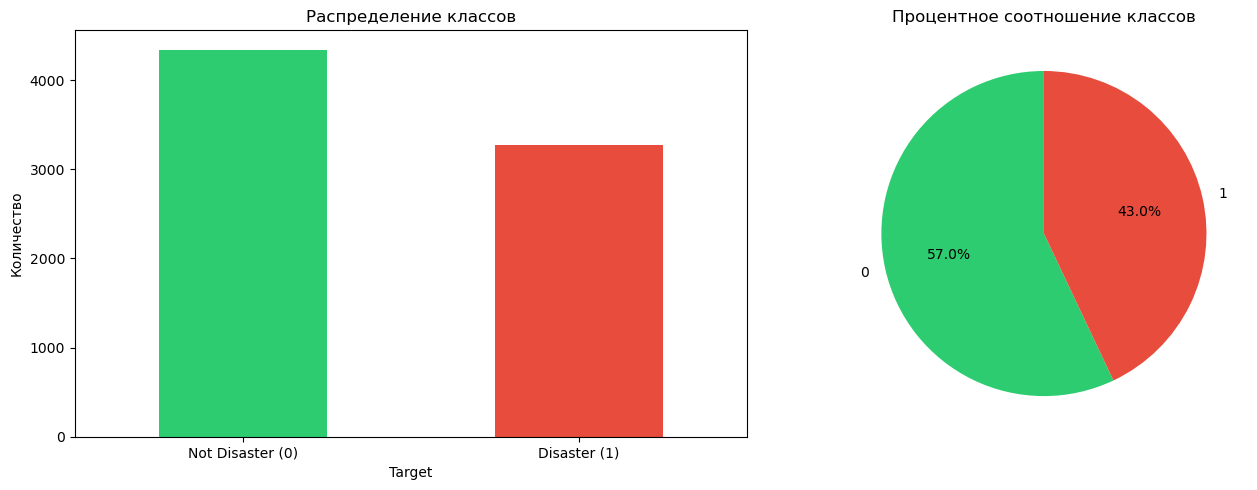

In [10]:
print("\nРаспределение классов:")
print(df['target'].value_counts())
print("\nПроцентное соотношение:")
print(df['target'].value_counts(normalize=True).round(4) * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['target'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Распределение классов')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['Not Disaster (0)', 'Disaster (1)'], rotation=0)

df['target'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                     colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Процентное соотношение классов')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

#### 3. Анализ длины текста и количества слов

Сначала поссчитаем длину твитов и количество слов. Посчитаем статистики и визуализируем их:

In [12]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

In [13]:

print("\nСтатистика длины текста:")
display(df.groupby('target')['text_length'].describe())

print("\nСтатистика количества слов:")
display(df.groupby('target')['word_count'].describe())


Статистика длины текста:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,95.706817,35.885924,7.0,68.0,101.0,130.0,157.0
1,3271.0,108.113421,29.309854,14.0,88.0,115.0,136.0,151.0



Статистика количества слов:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,14.704744,6.161564,1.0,10.0,15.0,19.0,31.0
1,3271.0,15.167533,5.096806,2.0,11.0,15.0,19.0,30.0


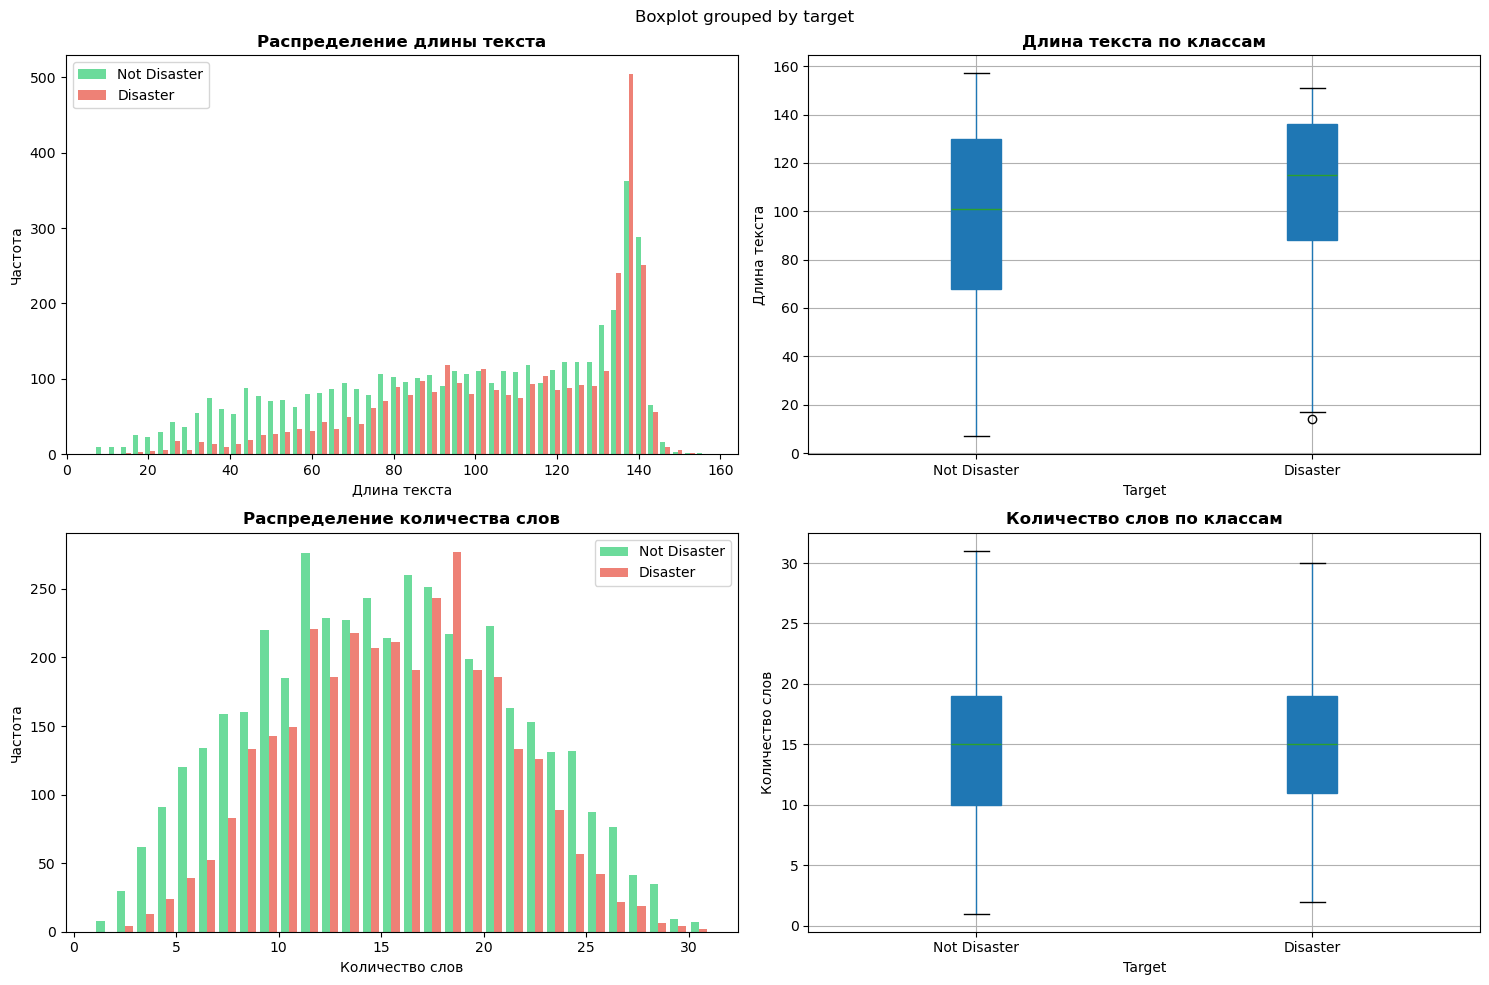

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist([df[df['target']==0]['text_length'], 
                 df[df['target']==1]['text_length']], 
                bins=50, label=['Not Disaster', 'Disaster'], alpha=0.7, color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Распределение длины текста', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Длина текста')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].legend()

df.boxplot(column='text_length', by='target', ax=axes[0, 1], patch_artist=True)
axes[0, 1].set_title('Длина текста по классам', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Target')
axes[0, 1].set_ylabel('Длина текста')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Not Disaster', 'Disaster'])

axes[1, 0].hist([df[df['target']==0]['word_count'], 
                 df[df['target']==1]['word_count']], 
                bins=30, label=['Not Disaster', 'Disaster'], alpha=0.7, color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_title('Распределение количества слов', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Количество слов')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].legend()

df.boxplot(column='word_count', by='target', ax=axes[1, 1], patch_artist=True)
axes[1, 1].set_title('Количество слов по классам', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Target')
axes[1, 1].set_ylabel('Количество слов')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['Not Disaster', 'Disaster'])

plt.tight_layout()
plt.show()


на графиках видно что оба класса сильно перекрываются по длине текста и числу слов, но у твитов с катастрофами есть сдвиг чуть более длинных сообщений и большего числа слов. 

также заметен ярко выраженный пик, скорее всего это ограничение по длине текста (135-140 символов) - значит много примеров было сжато к максимуму

медиана длины сообщений у твитов с катастрофами выше, то есть сообщения о происшествиях в среднем немного длиннее

наличие широких "усов" у обоих классов говорит о том, что встерчается и очень коротки и достаточно длинные тексты в обоих классах

#### 4. Анализ специальных символов 

Подсчитаем специальные символы, использующие в твитах. Рассчитаем их статистику и визуализируем:

In [16]:
df['hashtags_count'] = df['text'].apply(lambda x: len(re.findall(r'#\w+', str(x))))
df['mentions_count'] = df['text'].apply(lambda x: len(re.findall(r'@\w+', str(x))))
df['urls_count'] = df['text'].apply(lambda x: len(re.findall(r'http\S+|www\.\S+', str(x))))
df['numbers_count'] = df['text'].apply(lambda x: len(re.findall(r'\d+', str(x))))
df['capital_words_count'] = df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', str(x))))

special_features = ['hashtags_count', 'mentions_count', 'urls_count', 'numbers_count', 'capital_words_count']


Статистика специальных элементов по классам:

hashtags_count:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,0.388761,1.002390,0.0,0.0,0.0,0.0,11.0
1,3271.0,0.501987,1.184215,0.0,0.0,0.0,1.0,13.0



mentions_count:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,0.420313,0.769424,0.0,0.0,0.0,1.0,8.0
1,3271.0,0.272088,0.624632,0.0,0.0,0.0,0.0,5.0



urls_count:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,0.507600,0.668378,0.0,0.0,0.0,1.0,4.0
1,3271.0,0.770101,0.628360,0.0,0.0,1.0,1.0,3.0



numbers_count:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,1.096039,1.547151,0.0,0.0,0.0,2.0,19.0
1,3271.0,1.728829,1.867022,0.0,0.0,1.0,2.0,20.0



capital_words_count:


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,0.628512,1.970281,0.0,0.0,0.0,0.0,23.0
1,3271.0,0.652706,1.728823,0.0,0.0,0.0,1.0,21.0


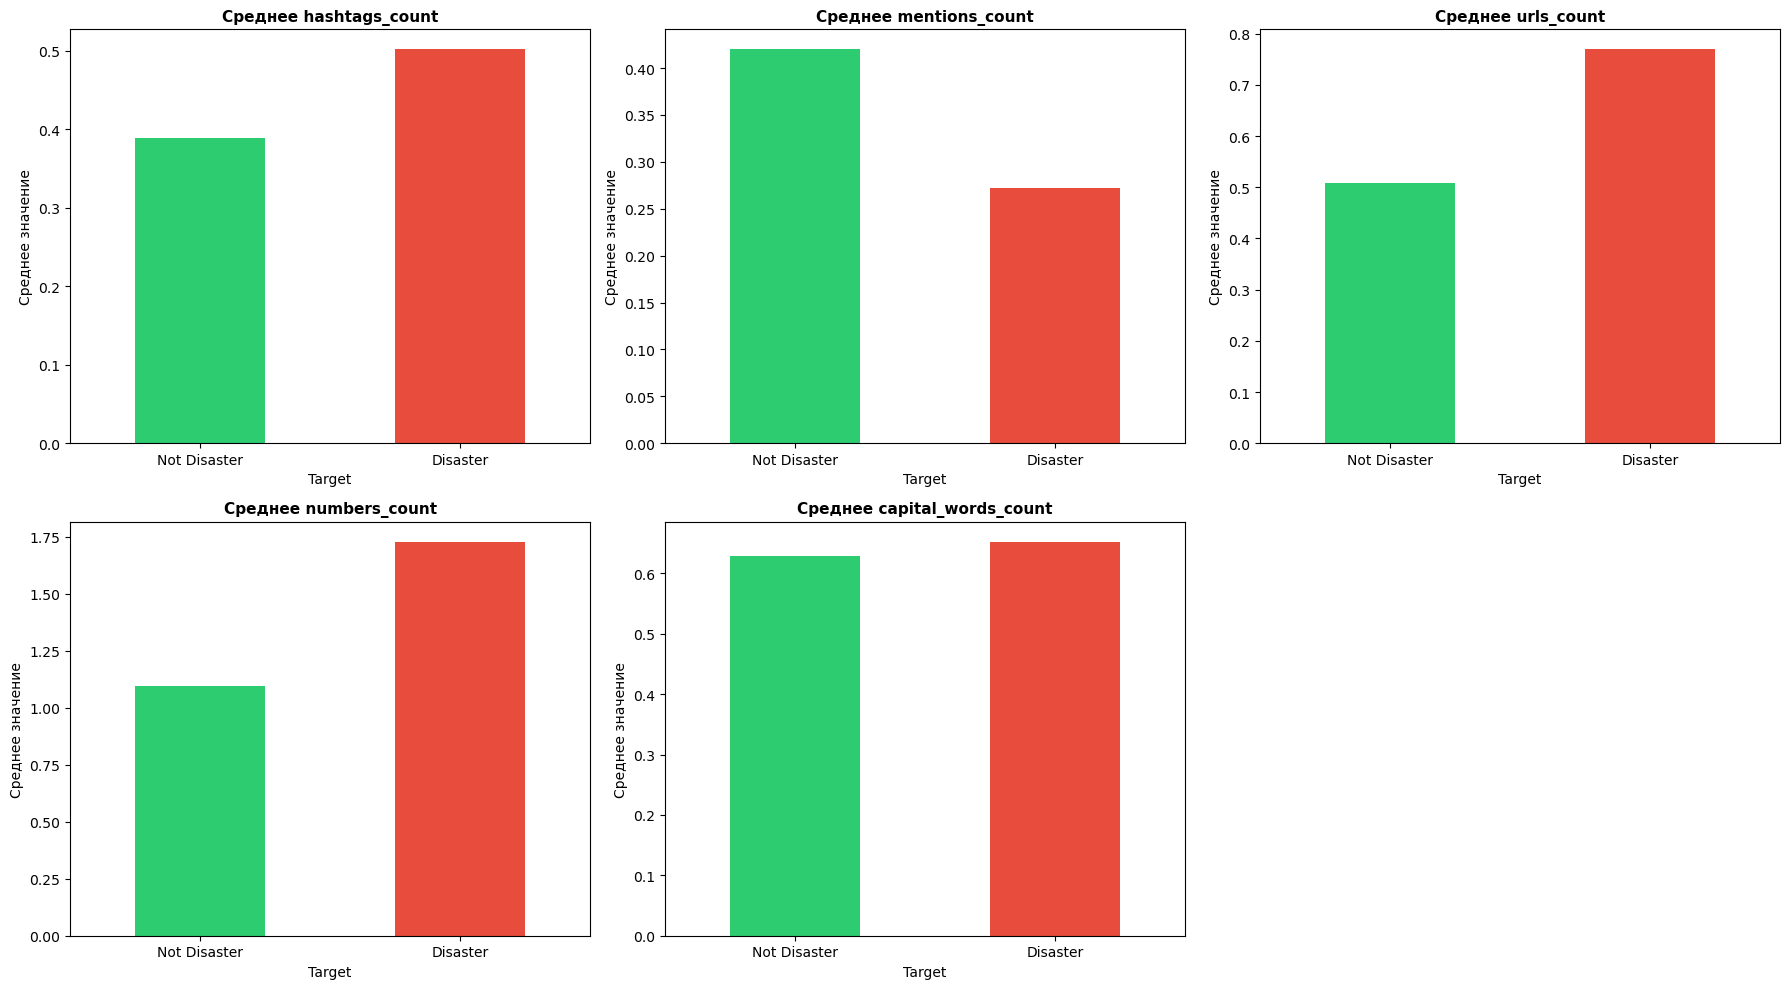

In [17]:
print("\nСтатистика специальных элементов по классам:")
for feature in special_features:
    print(f"\n{feature}:")
    display(df.groupby('target')[feature].describe())

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(special_features):
    df.groupby('target')[feature].mean().plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'Среднее {feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Target')
    axes[idx].set_ylabel('Среднее значение')
    axes[idx].set_xticklabels(['Not Disaster', 'Disaster'], rotation=0)

axes[5].axis('off')
plt.tight_layout()
plt.show()


у твитов с катастрофами:
- чаще встречаются хэштеги (среднее 0.50 vs 0.39; 75-й перцентиль 1 vs 0),
- заметно чаще есть ссылки (среднее 0.77 vs 0.51; медиана 1 vs 0),
- чаще присутствуют числа (среднее 1.73 vs 1.10; медиана 1 vs 0), 

для обычных твитов:
- характерны упоминания пользователей (среднее 0.42 vs 0.27; 75-й перцентиль 1 vs 0)

слова в капсе почти не различают классы (медиана 0 в обоих)

#### 5. Анализ поля keyword

Посчитаем пропущенные значения в столбце, кол-во уникальных элементов и выведем топ-20 самых частых элементов:

In [19]:
print(f"\nПропущенные значения: {df['keyword'].isnull().sum()} ({df['keyword'].isnull().sum()/len(df)*100:.2f}%)")
print(f"Уникальных keywords: {df['keyword'].nunique()}")

print("\nТоп-20 самых частых keywords:")
display(df['keyword'].value_counts().head(20))



Пропущенные значения: 61 (0.80%)
Уникальных keywords: 221

Топ-20 самых частых keywords:


keyword
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
sinking        41
evacuate       40
outbreak       40
fear           40
siren          40
windstorm      40
collided       40
twister        40
hellfire       39
famine         39
flames         39
weapon         39
wreckage       39
sunk           39
Name: count, dtype: int64

теперь проанализируем распределение целевой переменной по том словам из keywords:

In [20]:

# Распределение target по топ keywords
top_keywords = df['keyword'].value_counts().head(15).index
keyword_target_dist = df[df['keyword'].isin(top_keywords)].groupby(['keyword', 'target']).size().unstack(fill_value=0)
keyword_target_dist['total'] = keyword_target_dist.sum(axis=1)
keyword_target_dist['disaster_rate'] = (keyword_target_dist[1] / keyword_target_dist['total'] * 100).round(2)
keyword_target_dist = keyword_target_dist.sort_values('disaster_rate', ascending=False)

print("\nРаспределение target по топ-15 keywords:")
display(keyword_target_dist)


Распределение target по топ-15 keywords:


target,0,1,total,disaster_rate
keyword,,,,
outbreak,1,39,40,97.50
evacuate,15,25,40,62.50
fatalities,19,26,45,57.78
collided,17,23,40,57.50
damage,22,19,41,46.34
windstorm,24,16,40,40.00
sinking,33,8,41,19.51
hellfire,32,7,39,17.95
deluge,36,6,42,14.29


визуализируем для наглядности:

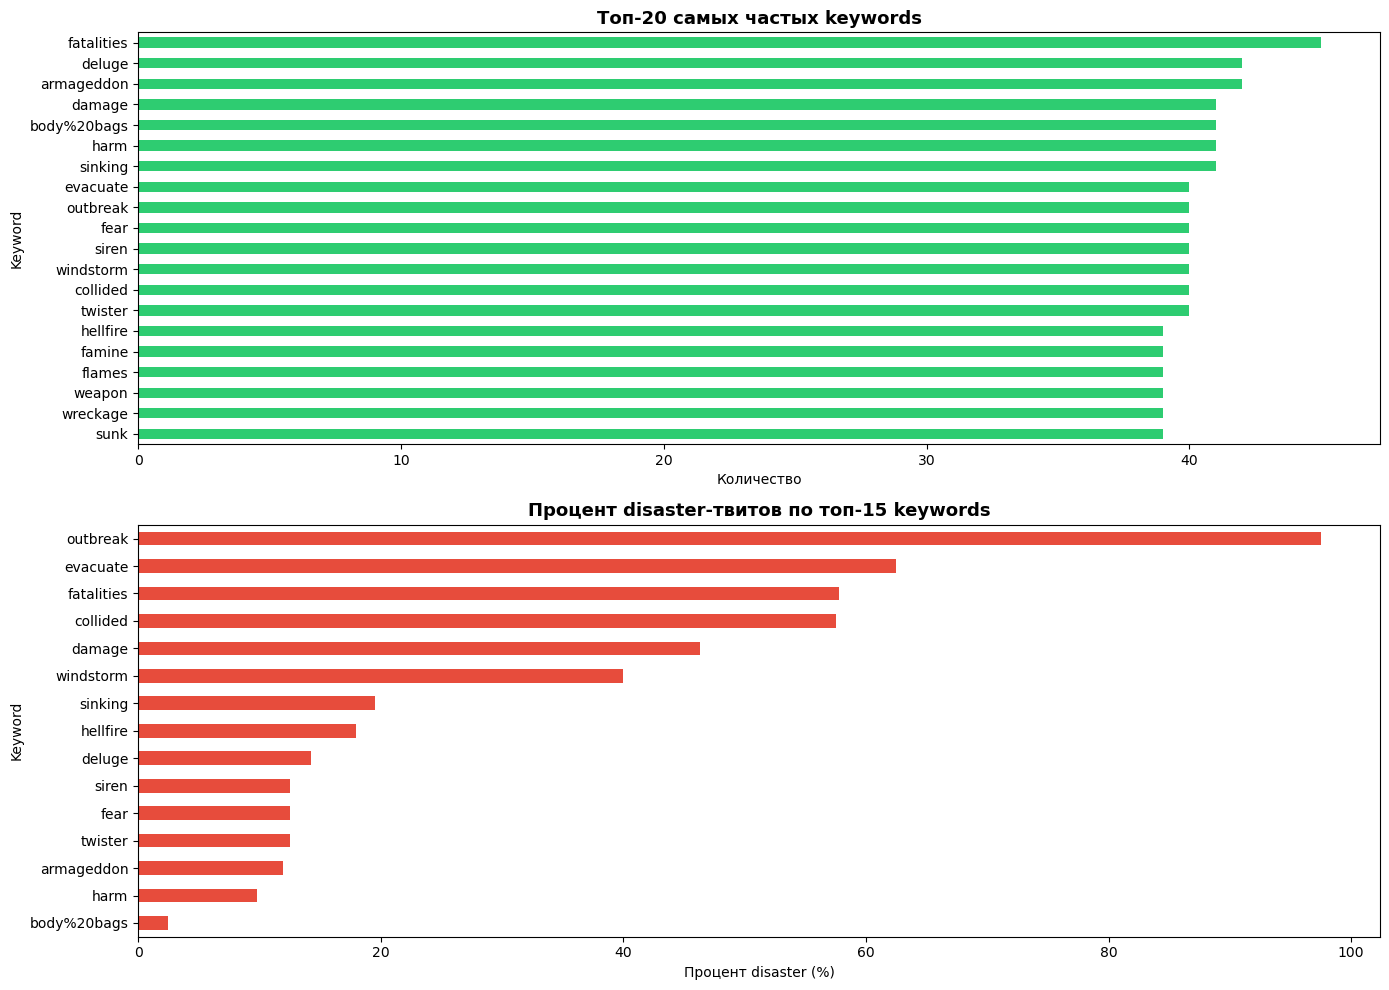

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

df['keyword'].value_counts().head(20).plot(kind='barh', ax=axes[0], color='#2ecc71')
axes[0].set_title('Топ-20 самых частых keywords', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Keyword')
axes[0].invert_yaxis()

keyword_target_dist['disaster_rate'].plot(kind='barh', ax=axes[1], color='#e74c3c')
axes[1].set_title('Процент disaster-твитов по топ-15 keywords', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Процент disaster (%)')
axes[1].set_ylabel('Keyword')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


По сементическому смыслу топ 20 самых частых слов в keywords - относятся к катастрофам, поэтому ожидаемо что многие из них будут коррелировать с таргетом

из нижнего графика, можно сделать вывод о том, что есть в keywords есть слова, которые повышают вероятность положительного класса (процент disaster > 50) и есть разговорные слова (twister, armageddon,...)

таким образом, признак является полезным и это надо будет учесть при моделировании

#### 6. Анализ поля location

Посчитаем пропущенные значения в столбце, кол-во уникальных элементов и выведем топ-20 самых частых элементов:

In [22]:

print(f"\nПропущенные значения: {df['location'].isnull().sum()} ({df['location'].isnull().sum()/len(df)*100:.2f}%)")
print(f"Уникальных locations: {df['location'].nunique()}")

print("\nТоп-20 самых частых locations:")
display(df['location'].value_counts().head(20))


Пропущенные значения: 2533 (33.27%)
Уникальных locations: 3341

Топ-20 самых частых locations:


location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
New York, NY        15
California, USA     15
Everywhere          15
San Francisco       14
Name: count, dtype: int64

Оценим распределение target по топ locations и визуализируем статистики:

In [23]:
# Распределение target по топ locations
top_locations = df['location'].value_counts().head(15).index
location_target_dist = df[df['location'].isin(top_locations)].groupby(['location', 'target']).size().unstack(fill_value=0)
location_target_dist['total'] = location_target_dist.sum(axis=1)
location_target_dist['disaster_rate'] = (location_target_dist[1] / location_target_dist['total'] * 100).round(2)
location_target_dist = location_target_dist.sort_values('disaster_rate', ascending=False)

print("\nРаспределение target по топ-15 locations:")
display(location_target_dist)


Распределение target по топ-15 locations:


target,0,1,total,disaster_rate
location,,,,
Mumbai,3,19,22,86.36
India,4,20,24,83.33
Nigeria,6,22,28,78.57
"Washington, DC",6,15,21,71.43
USA,37,67,104,64.42
Worldwide,7,12,19,63.16
UK,11,16,27,59.26
United States,23,27,50,54.00
"Chicago, IL",9,9,18,50.00


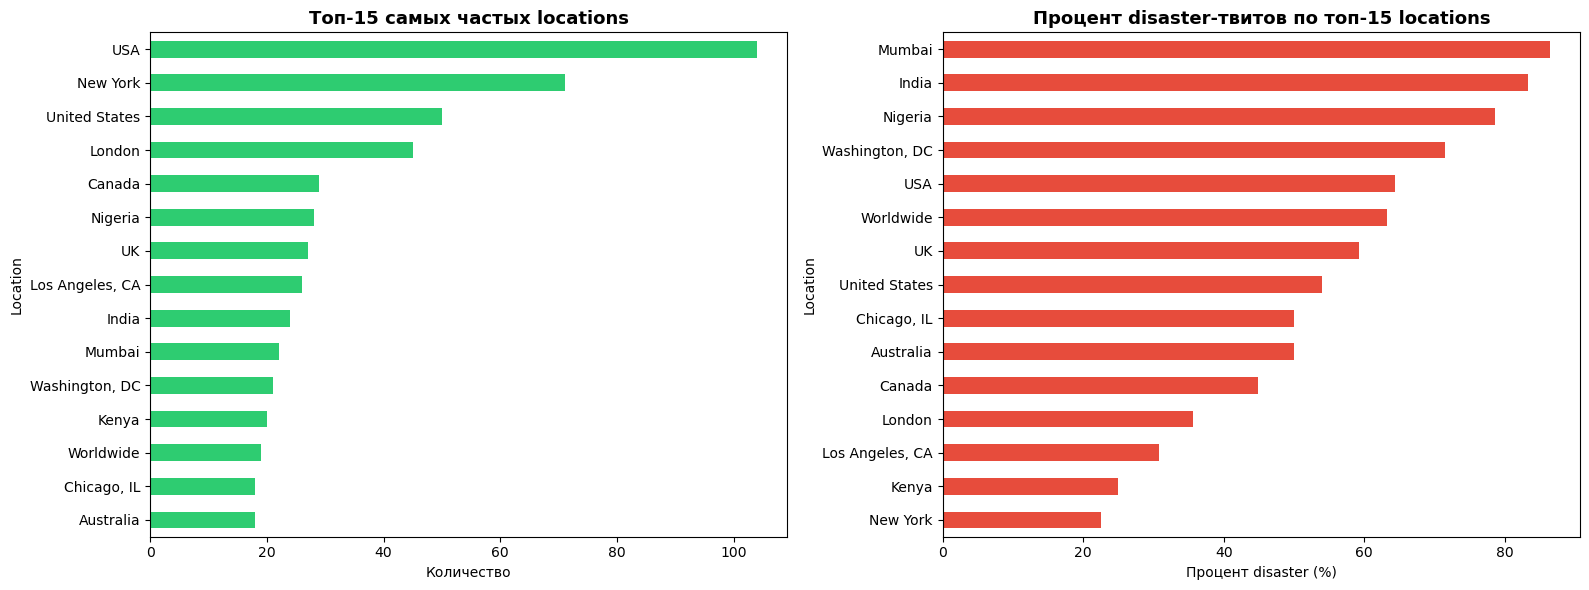

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df['location'].value_counts().head(15).plot(kind='barh', ax=axes[0], color='#2ecc71')
axes[0].set_title('Топ-15 самых частых locations', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Location')
axes[0].invert_yaxis()

location_target_dist['disaster_rate'].plot(kind='barh', ax=axes[1], color='#e74c3c')
axes[1].set_title('Процент disaster-твитов по топ-15 locations', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Процент disaster (%)')
axes[1].set_ylabel('Location')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


Частота не коррелирует с вероятностью катастрофы (например New York является вторым по популярности местоположением , но имеет самый низкий процент реальных сообщений о катастрофах среди топа)

Локации Mumbai, India и Nigeria  являются очень сильными маркерами положительного класса. Скорее всего этого связано с конкретными событиями, попавшим в датасет на момент его сбора

Видны дублирования (USA/United States, Los Angeles,CA)

Таким обраом, данный признак также информативен и будет учтен в дальнейшем


#### 7. Корреляционный анализ числовых признаков


Корреляция признаков с target:


target                 1.000000
urls_count             0.195631
numbers_count          0.182064
text_length            0.181817
hashtags_count         0.051633
word_count             0.039966
capital_words_count    0.006404
mentions_count        -0.102692
Name: target, dtype: float64

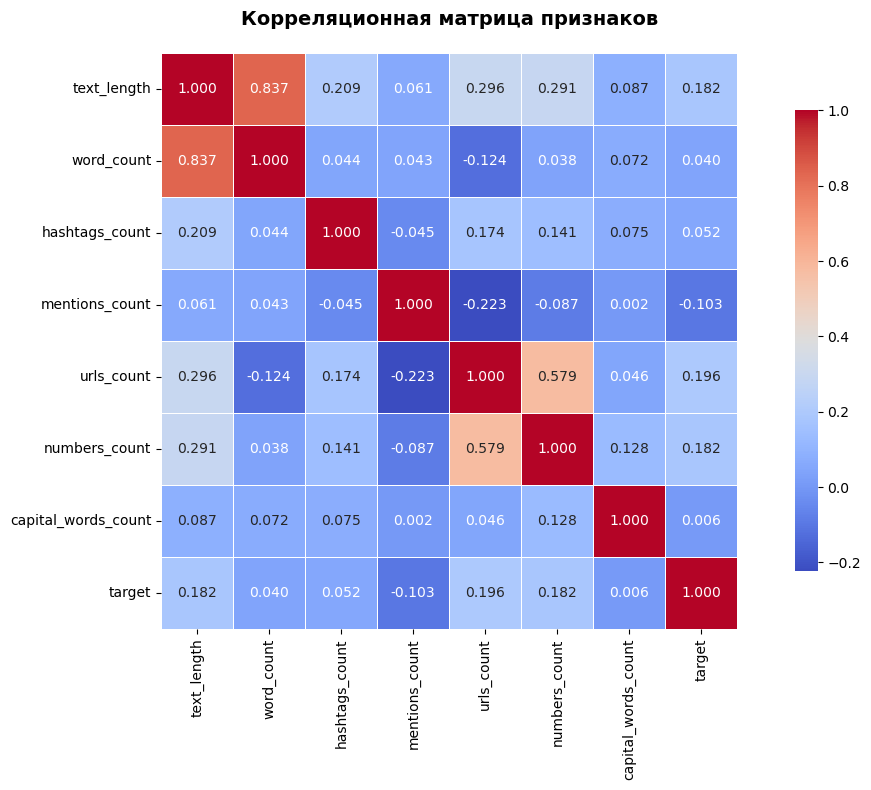

In [25]:
numeric_features = ['text_length', 'word_count', 'hashtags_count', 'mentions_count', 
                    'urls_count', 'numbers_count', 'capital_words_count', 'target']

correlation_matrix = df[numeric_features].corr()

print("\nКорреляция признаков с target:")
display(correlation_matrix['target'].sort_values(ascending=False))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


- твиты о реальных катастрофах гораздо чаще содержат ссылки на новостные статьи

- numbers_count: 0.182 и text_length: 0.182 говорит о том, что реальные твиты о ЧП содержат точные данные (например at 11:00, 10 killed и т.п.). также короткие твиты ("lol", "wow" и т.п.) чаще относятся к классу 0

- mentions_count: -0.103 - чем больше упоминаний пользоваталей (@username) в твите, тем меньше вероятность, что это реальная катастрофа

#### 8. Анализ наиболее частых слов

Посчитаем и визуализируем топ 25 слов в disaster и non-disaster твитах:


Топ-25 слов в disaster-твитах:
[('fire', 180), ('news', 138), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 107), ('people', 105), ('killed', 93), ('like', 92), ('hiroshima', 89), ('fires', 85), ('storm', 85), ('crash', 84), ('families', 81), ('train', 79), ('emergency', 76), ('bomb', 75), ('buildings', 75), ('two', 71), ('nuclear', 71), ('attack', 69), ('video', 69), ('wildfire', 69)]

Топ-25 слов в non-disaster твитах:
[('like', 253), ('amp', 193), ('new', 170), ('get', 163), ('dont', 154), ('one', 128), ('body', 113), ('via', 99), ('would', 97), ('video', 96), ('love', 90), ('people', 90), ('cant', 86), ('know', 85), ('time', 84), ('back', 84), ('got', 83), ('see', 82), ('full', 82), ('day', 81), ('emergency', 81), ('going', 75), ('still', 72), ('fire', 72), ('want', 67)]


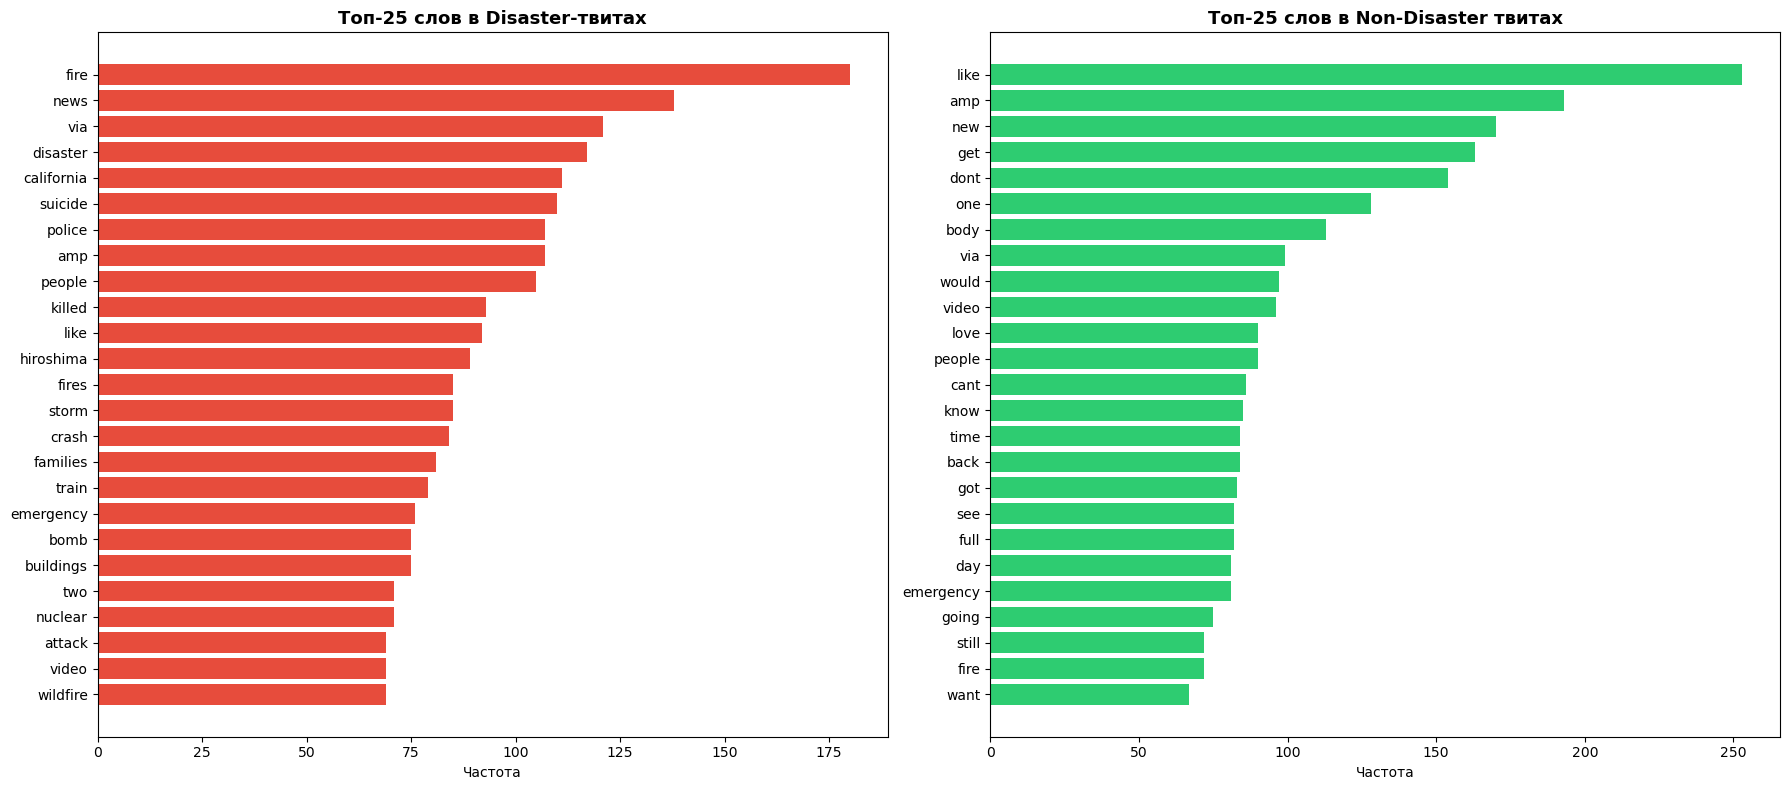

In [30]:
from eval_utils import get_top_words
from nltk.corpus import stopwords
import nltk
import re
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20, remove_stopwords=True):
    """Получение топ-N слов из текстов"""
    words = []
    for text in texts:
        text_lower = str(text).lower()
        text_cleaned = re.sub(r'http\S+|www\.\S+|@\w+|#|[^a-zA-Z\s]', '', text_lower)
        words.extend(text_cleaned.split())
    
    if remove_stopwords:
        words = [w for w in words if w not in stop_words and len(w) > 2]
    
    return Counter(words).most_common(n)
disaster_words = get_top_words(df[df['target']==1]['text'], n=25)
non_disaster_words = get_top_words(df[df['target']==0]['text'], n=25)

print("\nТоп-25 слов в disaster-твитах:")
print(disaster_words)

print("\nТоп-25 слов в non-disaster твитах:")
print(non_disaster_words)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

words_d, counts_d = zip(*disaster_words)
axes[0].barh(range(len(words_d)), counts_d, color='#E74C3C')
axes[0].set_yticks(range(len(words_d)))
axes[0].set_yticklabels(words_d)
axes[0].set_title('Топ-25 слов в Disaster-твитах', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Частота')
axes[0].invert_yaxis()

words_nd, counts_nd = zip(*non_disaster_words)
axes[1].barh(range(len(words_nd)), counts_nd, color='#2ecc71')
axes[1].set_yticks(range(len(words_nd)))
axes[1].set_yticklabels(words_nd)
axes[1].set_title('Топ-25 слов в Non-Disaster твитах', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Частота')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


Твиты с реальными происшествиями описывают события и имеют специфичные слова (suicide, nuclear, killed, hirosima, wildfire)

Обычные твиты - это эмоции и быт (like, love, want, know, think)

Есть слова которые встречаются в обоих классах (например fire - 180 раз в катастрофах и 24 раза в обычных)

Технические артефакты (amp - html код амперсанда, via - как ссылка на источник новостей)

И построим облако слов:

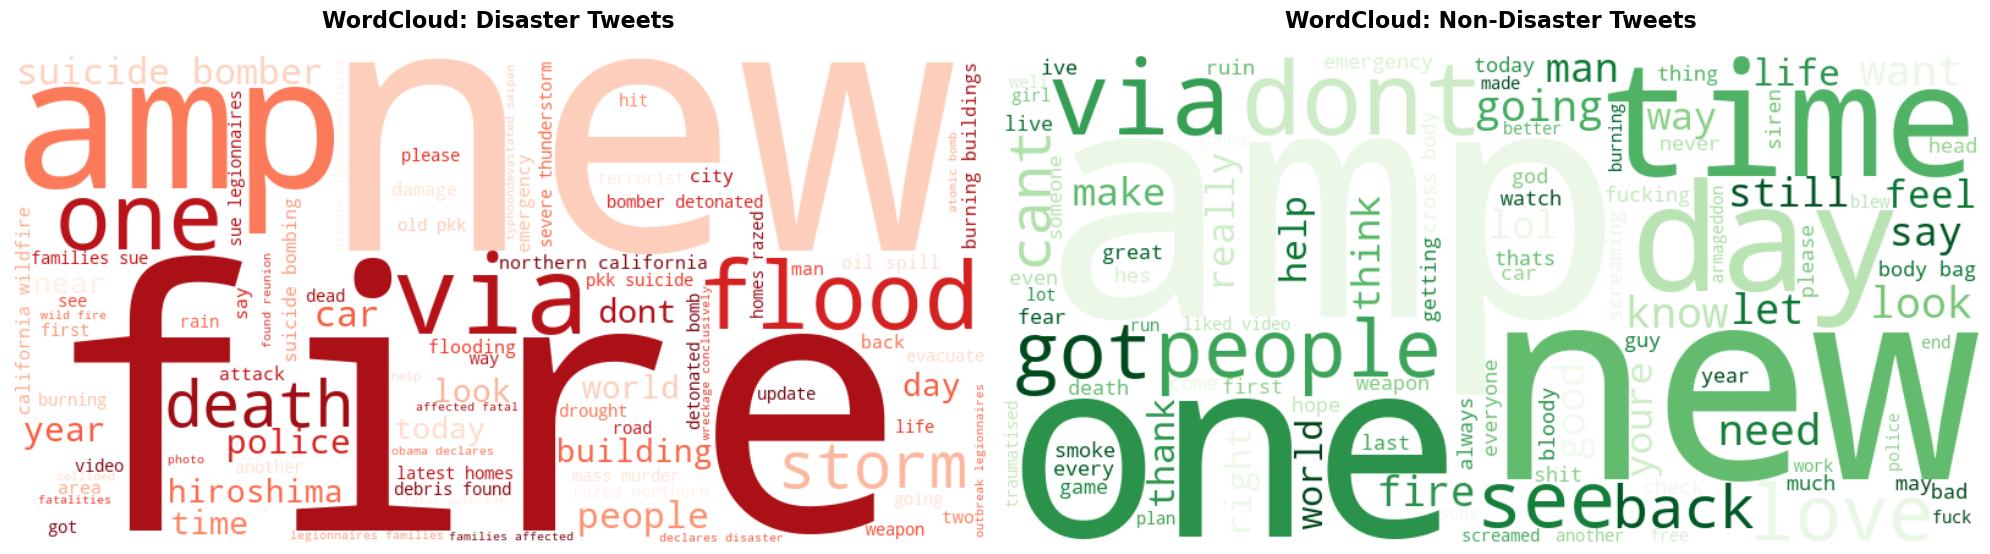

In [ ]:
disaster_text = prepare_text_for_wordcloud(df[df['target']==1]['text'])
non_disaster_text = prepare_text_for_wordcloud(df[df['target']==0]['text'])

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

wordcloud_disaster = WordCloud(width=800, height=400, 
                               background_color='white',
                               colormap='Reds',
                               max_words=100,
                               relative_scaling=0.5,
                               min_font_size=10).generate(disaster_text)

axes[0].imshow(wordcloud_disaster, interpolation='bilinear')
axes[0].set_title('WordCloud: Disaster Tweets', fontsize=16, fontweight='bold', pad=20)
axes[0].axis('off')

wordcloud_non_disaster = WordCloud(width=800, height=400,
                                   background_color='white',
                                   colormap='Greens',
                                   max_words=100,
                                   relative_scaling=0.5,
                                   min_font_size=10).generate(non_disaster_text)

axes[1].imshow(wordcloud_non_disaster, interpolation='bilinear')
axes[1].set_title('WordCloud: Non-Disaster Tweets', fontsize=16, fontweight='bold', pad=20)
axes[1].axis('off')

plt.tight_layout()
plt.show()

#### 9. Анализ важности токенов 

Будем исследовать n-граммы (n: 1,2,3). Для этого сначала их поссчитаем:

In [39]:
df['text_cleaned'] = df['text'].apply(clean_text)

In [40]:
disaster_texts = df[df['target']==1]['text_cleaned'].values
non_disaster_texts = df[df['target']==0]['text_cleaned'].values

disaster_unigrams = get_top_ngrams(disaster_texts, n=1, top=20)
non_disaster_unigrams = get_top_ngrams(non_disaster_texts, n=1, top=20)


disaster_bigrams = get_top_ngrams(disaster_texts, n=2, top=20)
non_disaster_bigrams = get_top_ngrams(non_disaster_texts, n=2, top=20)



disaster_trigrams = get_top_ngrams(disaster_texts, n=3, top=20)
non_disaster_trigrams = get_top_ngrams(non_disaster_texts, n=3, top=20)


Теперь визуализируем:

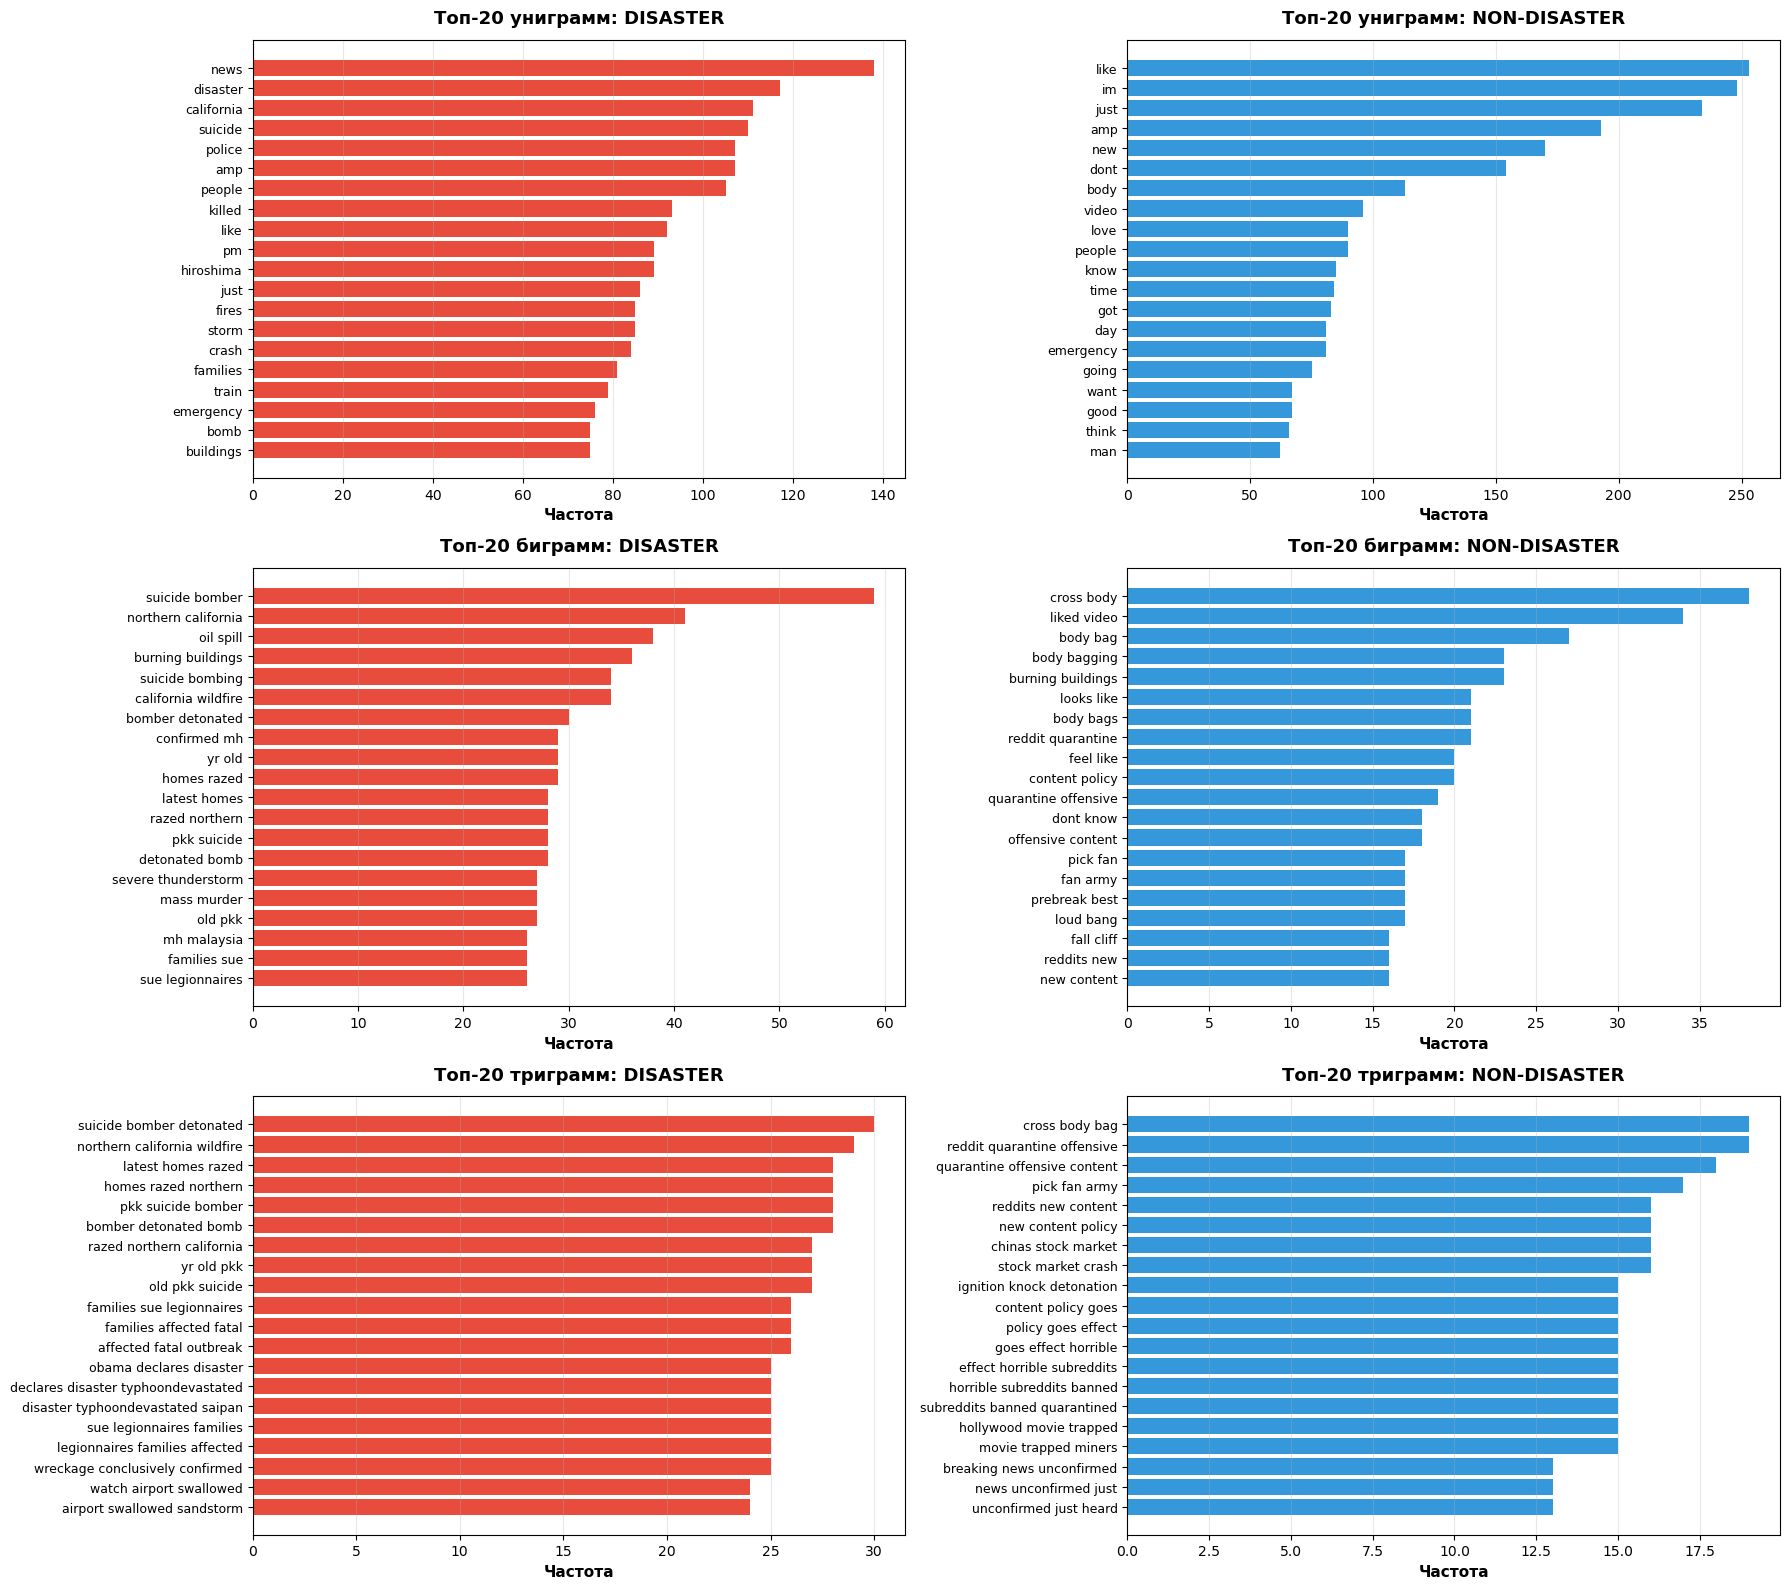

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

words_d, counts_d = zip(*disaster_unigrams)
axes[0, 0].barh(range(len(words_d)), counts_d, color='#E74C3C')
axes[0, 0].set_yticks(range(len(words_d)))
axes[0, 0].set_yticklabels(words_d, fontsize=9)
axes[0, 0].set_xlabel('Частота', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Топ-20 униграмм: DISASTER', fontsize=13, fontweight='bold', pad=12)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

words_nd, counts_nd = zip(*non_disaster_unigrams)
axes[0, 1].barh(range(len(words_nd)), counts_nd, color='#3498DB')
axes[0, 1].set_yticks(range(len(words_nd)))
axes[0, 1].set_yticklabels(words_nd, fontsize=9)
axes[0, 1].set_xlabel('Частота', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Топ-20 униграмм: NON-DISASTER', fontsize=13, fontweight='bold', pad=12)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

words_d2, counts_d2 = zip(*disaster_bigrams)
axes[1, 0].barh(range(len(words_d2)), counts_d2, color='#E74C3C')
axes[1, 0].set_yticks(range(len(words_d2)))
axes[1, 0].set_yticklabels(words_d2, fontsize=9)
axes[1, 0].set_xlabel('Частота', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Топ-20 биграмм: DISASTER', fontsize=13, fontweight='bold', pad=12)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

words_nd2, counts_nd2 = zip(*non_disaster_bigrams)
axes[1, 1].barh(range(len(words_nd2)), counts_nd2, color='#3498DB')
axes[1, 1].set_yticks(range(len(words_nd2)))
axes[1, 1].set_yticklabels(words_nd2, fontsize=9)
axes[1, 1].set_xlabel('Частота', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Топ-20 биграмм: NON-DISASTER', fontsize=13, fontweight='bold', pad=12)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

words_d3, counts_d3 = zip(*disaster_trigrams)
axes[2, 0].barh(range(len(words_d3)), counts_d3, color='#E74C3C')
axes[2, 0].set_yticks(range(len(words_d3)))
axes[2, 0].set_yticklabels(words_d3, fontsize=9)
axes[2, 0].set_xlabel('Частота', fontsize=11, fontweight='bold')
axes[2, 0].set_title('Топ-20 триграмм: DISASTER', fontsize=13, fontweight='bold', pad=12)
axes[2, 0].invert_yaxis()
axes[2, 0].grid(axis='x', alpha=0.3)

words_nd3, counts_nd3 = zip(*non_disaster_trigrams)
axes[2, 1].barh(range(len(words_nd3)), counts_nd3, color='#3498DB')
axes[2, 1].set_yticks(range(len(words_nd3)))
axes[2, 1].set_yticklabels(words_nd3, fontsize=9)
axes[2, 1].set_xlabel('Частота', fontsize=11, fontweight='bold')
axes[2, 1].set_title('Топ-20 триграмм: NON-DISASTER', fontsize=13, fontweight='bold', pad=12)
axes[2, 1].invert_yaxis()
axes[2, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_classif
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+|@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text
def get_top_ngrams_anova(corpus, target, n=None, top=20):
    """
    Извлечение топ n-грамм на основе ANOVA F-value.
    corpus: весь столбец текстов
    target: столбец меток классов
    """
    # Векторизация
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english', min_df=3)
    X = vec.fit_transform(corpus)
    feature_names = vec.get_feature_names_out()
    
    # ПРЕОБРАЗОВАНИЕ TARGET В NUMPY МАССИВ
    # Это решает ошибку AttributeError: 'Series' object has no attribute 'nonzero'
    y = target.values
    
    # Вычисление ANOVA F-value
    f_scores, p_values = f_classif(X, y)
    
    # Разделение матрицы по классам, используя numpy array 'y'
    X_disaster = X[y == 1]
    X_non_disaster = X[y == 0]
    
    # Средняя частота слова в каждом классе
    mean_disaster = np.array(X_disaster.mean(axis=0)).flatten()
    mean_non_disaster = np.array(X_non_disaster.mean(axis=0)).flatten()
    
    disaster_feats = []
    non_disaster_feats = []
    
    for i, word in enumerate(feature_names):
        score = f_scores[i]
        
        # Пропускаем NaN/Inf
        if np.isnan(score) or np.isinf(score):
            continue
            
        # Определяем направление важности (для какого класса это слово характерно)
        if mean_disaster[i] > mean_non_disaster[i]:
            disaster_feats.append((word, score))
        else:
            non_disaster_feats.append((word, score))
            
    # Сортировка по F-score
    disaster_top = sorted(disaster_feats, key=lambda x: x[1], reverse=True)[:top]
    non_disaster_top = sorted(non_disaster_feats, key=lambda x: x[1], reverse=True)[:top]
    
    return disaster_top, non_disaster_top

def plot_ngram(ax, data, title, color):
    if not data: return
    words, scores = zip(*data)
    ax.barh(range(len(words)), scores, color=color)
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, fontsize=9)
    ax.set_xlabel('ANOVA F-Score (Важность)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

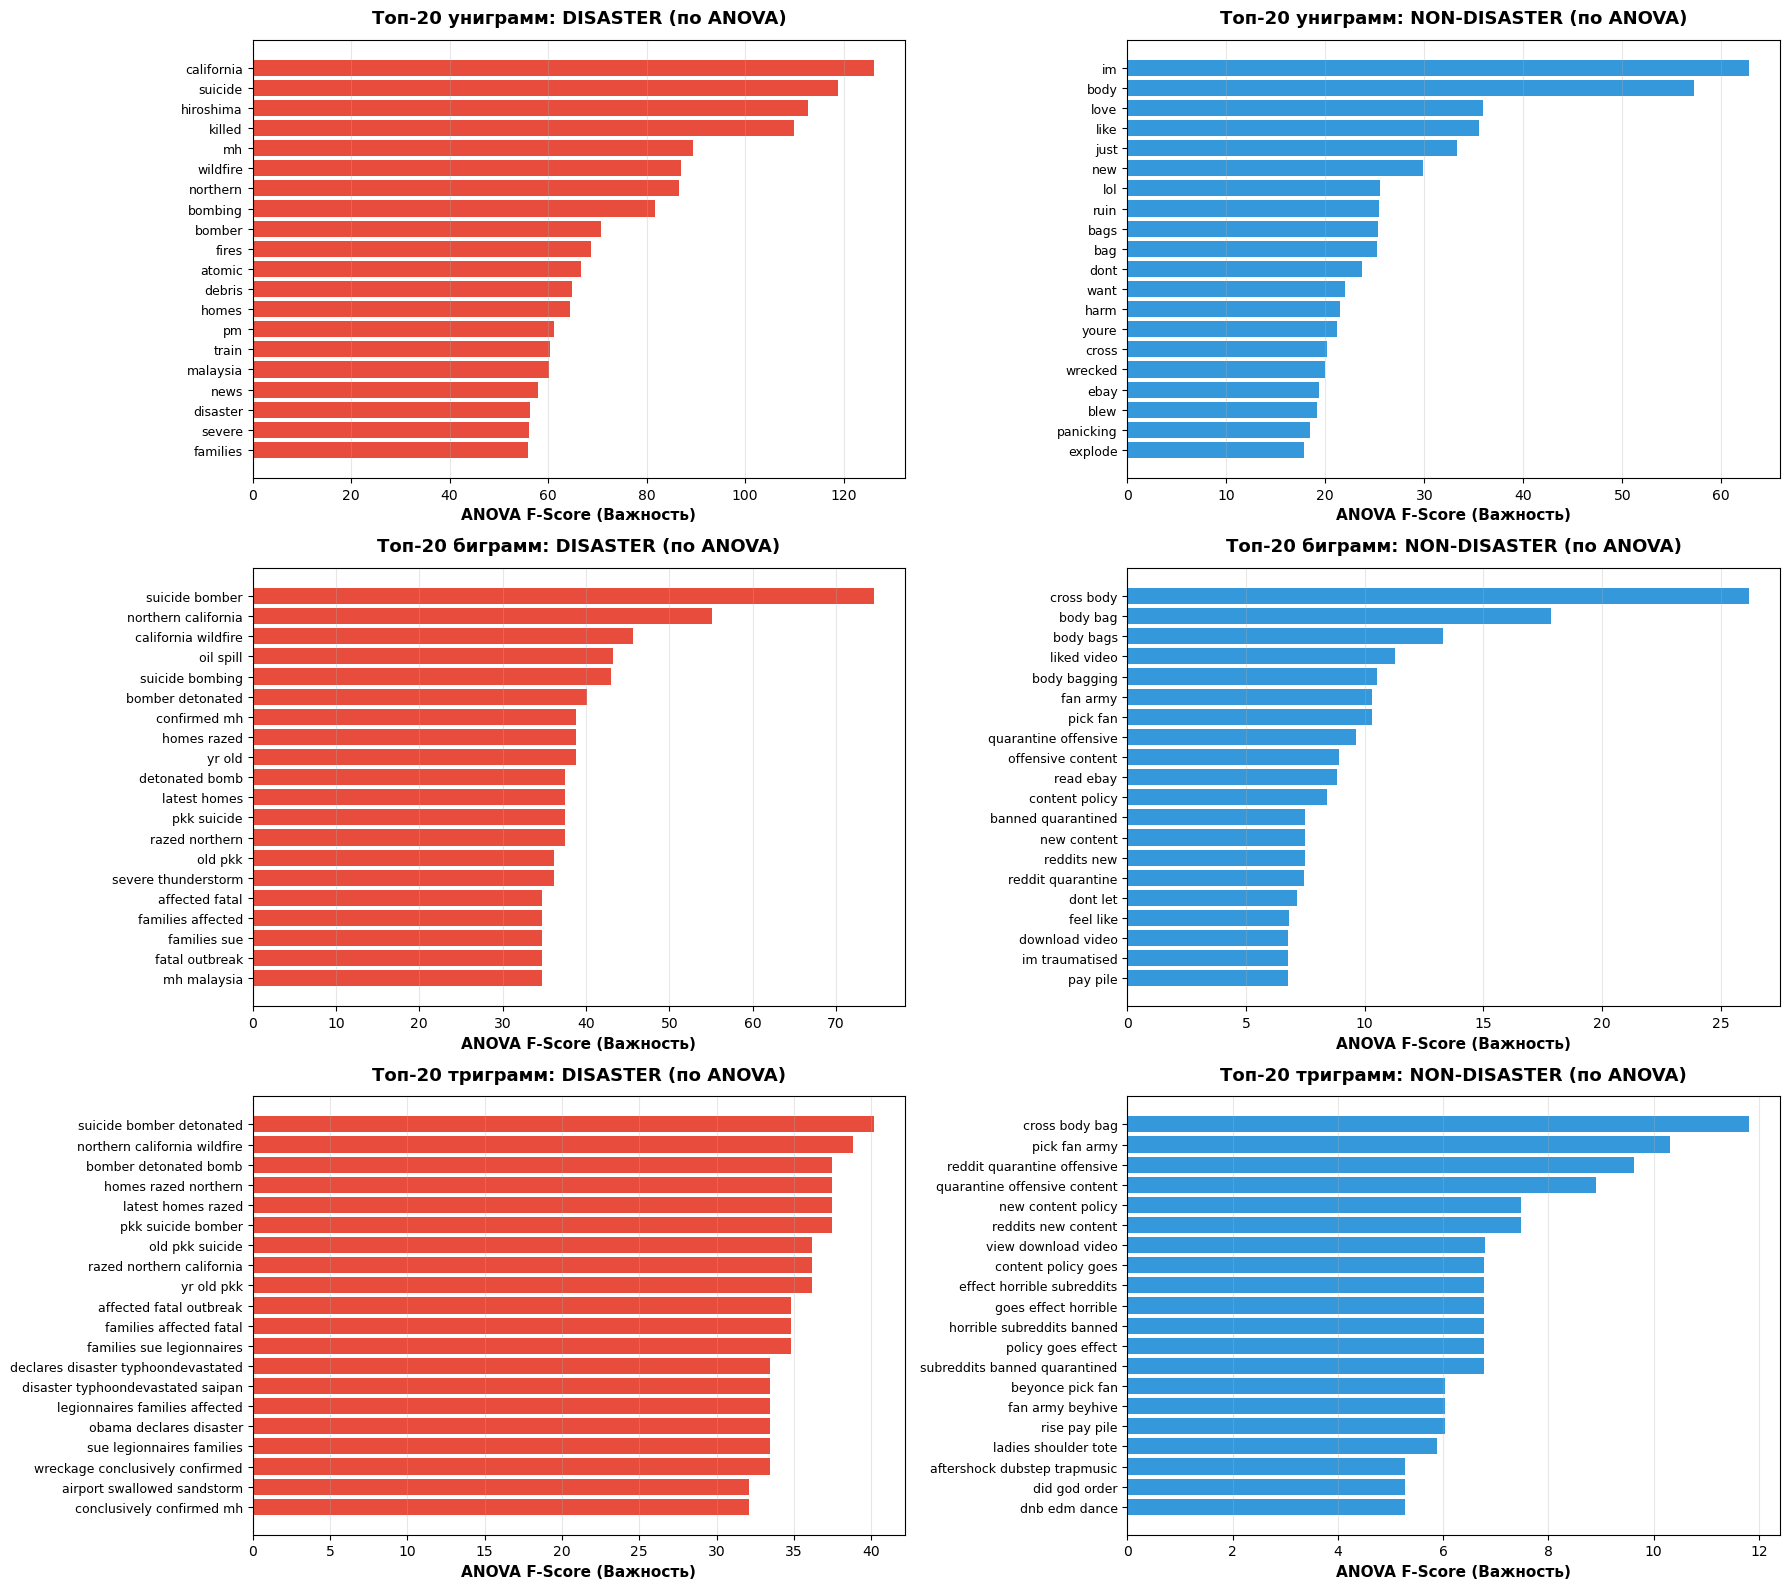

In [49]:
df['text_cleaned'] = df['text'].apply(clean_text)

full_text = df['text_cleaned']
targets = df['target']

d_uni, nd_uni = get_top_ngrams_anova(full_text, targets, n=1, top=20)

d_bi, nd_bi = get_top_ngrams_anova(full_text, targets, n=2, top=20)

d_tri, nd_tri = get_top_ngrams_anova(full_text, targets, n=3, top=20)

fig, axes = plt.subplots(3, 2, figsize=(18, 16))

plot_ngram(axes[0, 0], d_uni, 'Топ-20 униграмм: DISASTER (по ANOVA)', '#E74C3C')
plot_ngram(axes[0, 1], nd_uni, 'Топ-20 униграмм: NON-DISASTER (по ANOVA)', '#3498DB')

plot_ngram(axes[1, 0], d_bi, 'Топ-20 биграмм: DISASTER (по ANOVA)', '#E74C3C')
plot_ngram(axes[1, 1], nd_bi, 'Топ-20 биграмм: NON-DISASTER (по ANOVA)', '#3498DB')

plot_ngram(axes[2, 0], d_tri, 'Топ-20 триграмм: DISASTER (по ANOVA)', '#E74C3C')
plot_ngram(axes[2, 1], nd_tri, 'Топ-20 триграмм: NON-DISASTER (по ANOVA)', '#3498DB')

plt.tight_layout()
plt.show()

- при моделировании необходимо будет учитывать биграммы или триграммы, т.к. в они дают необходимый контекст. Например body - должно асоциироваться с жертвами катастроф, но если взглянуть на n-граммы видим cross-body и cross body bag

- слова im, just, like, lol являются хорошими предикторами отсутствия катастрофы. При удалении их со стоп словами может привести снижению предсказательной способности модели